In [1]:
import spacy

import re#, string, unicodedata
import nltk
import pandas as pd
import numpy as np 

from sklearn.metrics import confusion_matrix, f1_score,  precision_score, recall_score, accuracy_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/parisa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Parse text attack logs

In [2]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
   
def remove_brackets(sample_str):
    sample_str = sample_str.replace("[[", "")
    sample_str = sample_str.replace("]]", "")
    return sample_str

def clean_up_list(str_list):
    final_list=[]
    for item in str_list:
        final_list.append(remove_brackets(item))
    return final_list

def comparing(lst1, lst2):
    items = intersection(lst1, lst2)
    return len(items), items

# Generate a report from the imtersection between 2 different arracks
def intersection_report(failed_lst1, failed_lst2,succeeded_lst1, succeeded_lst2, attack1, attack2):
    
    f_intersect_num, f_intersect_items = comparing(failed_lst1, failed_lst2)
    print('Intersection number of failed examples between', attack1, 'and', attack2, sep=" ")
    print(f_intersect_num)
   
    s_intersect_num, s_intersect_items = comparing(succeeded_lst1, succeeded_lst2)
    print('Intersection number of succeeded examples between', attack1, 'and', attack2, sep=" ")
    print(s_intersect_num)
    
    return f_intersect_items, s_intersect_items

# Parse textattack results
def parse_text_file(filename):
    # Constant Variable
    divide_section_string = '--------------------------------------------- Result'
    # Initialize variable
    count = 0
    failed_examples = []
    succeeded_examples = []
    attack_examples = []
    # Read text file line by line
    f = open(filename, 'r')
    lines = f.readlines()
   
    pattern = re.compile(r'\[\[[0-9a-zA-Z\'\-]+\]\]')

    while count < len(lines):
        if divide_section_string in lines[count]: 
            count += 1
            if '[[[FAILED]]]' in lines[count] or '[[SKIPPED]]' in lines[count]:
                count += 2
                failed_examples.append(lines[count])
            else:
                count += 2
                succeeded_examples.append(lines[count])
                count += 2
                attack_examples.append(lines[count])
            count +=1
        count += 1       

    return failed_examples, succeeded_examples, attack_examples

### Extract purturbed words from attack examples 

In [3]:
def extract_label(t_s_result,df_ref):

    df_text = df_ref['text'].tolist()
    df_label = df_ref['label'].tolist()
    
    for i in range(len(df_text)):
        df_text[i] = df_text[i].replace('\n', '')
    
    prediction = []

    indexes = []
    for i in range(len(t_s_result)):
        #print(i)
        indexes.append(df_text.index(t_s_result[i].replace('\n', '')))
   
    for i in range(len(df_label)):
        if i in indexes:
            if df_ref.iloc[i]['label'] == 0:
                prediction.append(1)
            else:
                prediction.append(0)
        else:
            prediction.append(df_ref.iloc[i]['label'])
    
    #print(indexes)
    return prediction

## Confusion matrix visualization

In [4]:
# Visualize confusion matrix
def confusion_show(cf_matrix, model ,attack):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_title(model + ' under ' + attack + ' Attack Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Legit','Phish'])
    ax.yaxis.set_ticklabels(['Legit','Phish'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Print performance metric

In [5]:
def print_metrics(y_true,prediction):
    print('Accuracy', accuracy_score(y_true,prediction))
    print('F1 Score:', f1_score(y_true,prediction))
    print('Precision:', precision_score(y_true,prediction))
    print('Recall Score:', recall_score(y_true,prediction))
    print('MCC: ', matthews_corrcoef(y_true,prediction))

### Import textattack results from performing different attack method

## ALBERT with adversarial data

In [8]:
df_test = pd.read_csv('textattack-logs/test_f_adv.csv')

t_failed_examples, t_succeeded_examples, t_attack_examples = parse_text_file('textattack-logs/textfooler_albert_adv_1')
p_failed_examples, p_succeeded_examples, p_attack_examples = parse_text_file('textattack-logs/pwws_albert_adv_1')
d_failed_examples, d_succeeded_examples, d_attack_examples = parse_text_file('textattack-logs/deepwordbug_albert_adv_1')
b_failed_examples, b_succeeded_examples, b_attack_examples = parse_text_file('textattack-logs/bae_albert_adv_1')



t_s_result = clean_up_list(t_succeeded_examples)
p_s_result = clean_up_list(p_succeeded_examples)
d_s_result = clean_up_list(d_succeeded_examples)
b_s_result = clean_up_list(b_succeeded_examples)


prediction_t = extract_label(t_s_result,df_test)
prediction_p = extract_label(p_s_result,df_test)
prediction_d = extract_label(d_s_result,df_test)
prediction_b = extract_label(b_s_result,df_test)

y_true = df_test['label'].tolist()

In [9]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t)

print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p)

print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d)

print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b)

***********
Textfooler
***********
Accuracy 0.7597684515195369
F1 Score: 0.30833333333333335
Precision: 0.5211267605633803
Recall Score: 0.21893491124260356
MCC:  0.2177269616004682
***********
PWWS
***********
Accuracy 0.7945007235890015
F1 Score: 0.3931623931623932
Precision: 0.7076923076923077
Recall Score: 0.27218934911242604
MCC:  0.34718564904570537
***********
DeepWordBug
***********
Accuracy 0.7785817655571635
F1 Score: 0.32599118942731276
Precision: 0.6379310344827587
Recall Score: 0.21893491124260356
MCC:  0.2770125974225927
***********
BAE
***********
Accuracy 0.9059334298118669
F1 Score: 0.7896440129449838
Precision: 0.8714285714285714
Recall Score: 0.7218934911242604
MCC:  0.7351146790797448


## ALBERT with half of adversarial data

In [10]:
df_test = pd.read_csv('textattack-logs/test_f_adv_half.csv')

t_failed_examples, t_succeeded_examples, t_attack_examples = parse_text_file('textattack-logs/textfooler_albert_adv_half_1')
p_failed_examples, p_succeeded_examples, p_attack_examples = parse_text_file('textattack-logs/pwws_albert_adv_half_1')
d_failed_examples, d_succeeded_examples, d_attack_examples = parse_text_file('textattack-logs/deepwordbug_albert_adv_half_1')
b_failed_examples, b_succeeded_examples, b_attack_examples = parse_text_file('textattack-logs/bae_albert_adv_half_1')



t_s_result = clean_up_list(t_succeeded_examples)
p_s_result = clean_up_list(p_succeeded_examples)
d_s_result = clean_up_list(d_succeeded_examples)
b_s_result = clean_up_list(b_succeeded_examples)


prediction_t = extract_label(t_s_result,df_test)
prediction_p = extract_label(p_s_result,df_test)
prediction_d = extract_label(d_s_result,df_test)
prediction_b = extract_label(b_s_result,df_test)

y_true = df_test['label'].tolist()

In [68]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t)
#print(confusion_matrix(y_true, prediction_t + prediction_t_400))

#confusion_show(confusion_matrix(y_true, prediction_t + prediction_t_400), 'ALBERT', 'Textfooler')
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p)
#print(confusion_matrix(y_true, prediction_p + prediction_p_400))
#confusion_show(confusion_matrix(y_true, prediction_p + prediction_p_400), 'ALBERT', 'PWWS')
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d)
#print(confusion_matrix(y_true, prediction_d + prediction_d_400))
#confusion_show(confusion_matrix(y_true, prediction_d + prediction_d_400), 'ALBERT', 'DeepWordBug')
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b)

***********
Textfooler
***********
Accuracy 0.6589403973509934
F1 Score: 0.24817518248175185
Precision: 0.2111801242236025
Recall Score: 0.3008849557522124
MCC:  0.03724581824787409
***********
PWWS
***********
Accuracy 0.793046357615894
F1 Score: 0.4343891402714932
Precision: 0.4444444444444444
Recall Score: 0.4247787610619469
MCC:  0.3079401214687558
***********
DeepWordBug
***********
Accuracy 0.7980132450331126
F1 Score: 0.4077669902912622
Precision: 0.45161290322580644
Recall Score: 0.37168141592920356
MCC:  0.2893727893183148
***********
BAE
***********
Accuracy 0.8857615894039735
F1 Score: 0.7396226415094339
Precision: 0.6447368421052632
Recall Score: 0.8672566371681416
MCC:  0.6805244374662863


### ALBERT

In [13]:
df_test = pd.read_csv('textattack-logs/test_emails.csv')

t_failed_examples, t_succeeded_examples, t_attack_examples = parse_text_file('textattack-logs/albert_textfooler')
p_failed_examples, p_succeeded_examples, p_attack_examples = parse_text_file('textattack-logs/albert_pwws')
d_failed_examples, d_succeeded_examples, d_attack_examples = parse_text_file('textattack-logs/albert_deepwordbug')
b_failed_examples, b_succeeded_examples, b_attack_examples = parse_text_file('textattack-logs/albert_bae')

t_400_failed_examples, t_400_succeeded_examples, t_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_albert')
p_400_failed_examples, p_400_succeeded_examples, p_400_attack_examples = parse_text_file('textattack-logs/400_pwws_albert')
d_400_failed_examples, d_400_succeeded_examples, d_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_albert')
b_400_failed_examples, b_400_succeeded_examples, b_400_attack_examples = parse_text_file('textattack-logs/400_bae_albert')

t_s_result = clean_up_list(t_succeeded_examples)
p_s_result = clean_up_list(p_succeeded_examples)
d_s_result = clean_up_list(d_succeeded_examples)
b_s_result = clean_up_list(b_succeeded_examples)
                                                                                              


t_s_400_result = clean_up_list(t_400_succeeded_examples)
p_s_400_result = clean_up_list(p_400_succeeded_examples)
d_s_400_result = clean_up_list(d_400_succeeded_examples)
b_s_400_result = clean_up_list(b_400_succeeded_examples)


prediction_t = extract_label(t_s_result,df_test.iloc[:100])
prediction_p = extract_label(p_s_result,df_test.iloc[:100])
prediction_d = extract_label(d_s_result,df_test.iloc[:100])
prediction_b = extract_label(b_s_result,df_test.iloc[:100])

prediction_t_400 = extract_label(t_s_400_result,df_test.iloc[100:])
prediction_p_400 = extract_label(p_s_400_result,df_test.iloc[100:])
prediction_d_400 = extract_label(d_s_400_result,df_test.iloc[100:])
prediction_b_400 = extract_label(b_s_400_result,df_test.iloc[100:])


y_true = df_test['label'].tolist()


print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t + prediction_t_400)
#print(confusion_matrix(y_true, prediction_t + prediction_t_400))

#confusion_show(confusion_matrix(y_true, prediction_t + prediction_t_400), 'ALBERT', 'Textfooler')
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p + prediction_p_400)
#print(confusion_matrix(y_true, prediction_p + prediction_p_400))
#confusion_show(confusion_matrix(y_true, prediction_p + prediction_p_400), 'ALBERT', 'PWWS')
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d + prediction_d_400)
#print(confusion_matrix(y_true, prediction_d + prediction_d_400))
#confusion_show(confusion_matrix(y_true, prediction_d + prediction_d_400), 'ALBERT', 'DeepWordBug')
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b + prediction_b_400)
#print(confusion_matrix(y_true, prediction_b + prediction_b_400))
#confusion_show(confusion_matrix(y_true, prediction_b + prediction_b_400), 'ALBERT', 'BAE')


***********
Textfooler
***********
Accuracy 0.7876447876447876
F1 Score: 0.08333333333333333
Precision: 0.07936507936507936
Recall Score: 0.08771929824561403
MCC:  -0.03647289311171776
***********
PWWS
***********
Accuracy 0.8648648648648649
F1 Score: 0.12499999999999997
Precision: 0.21739130434782608
Recall Score: 0.08771929824561403
MCC:  0.07394624689163928
***********
DeepWordBug
***********
Accuracy 0.8725868725868726
F1 Score: 0.13157894736842105
Precision: 0.2631578947368421
Recall Score: 0.08771929824561403
MCC:  0.09547689535246852
***********
BAE
***********
Accuracy 0.9517374517374517
F1 Score: 0.8
Precision: 0.7352941176470589
Recall Score: 0.8771929824561403
MCC:  0.7766897872335184


[[403  58]
 [ 52   5]]


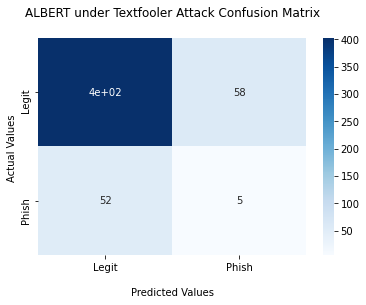

In [14]:
print(confusion_matrix(y_true, prediction_t + prediction_t_400))
confusion_show(confusion_matrix(y_true, prediction_t + prediction_t_400), 'ALBERT', 'Textfooler')

[[443  18]
 [ 52   5]]


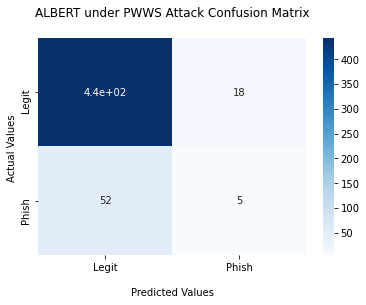

In [15]:
print(confusion_matrix(y_true, prediction_p + prediction_p_400))
confusion_show(confusion_matrix(y_true, prediction_p + prediction_p_400), 'ALBERT', 'PWWS')

[[447  14]
 [ 52   5]]


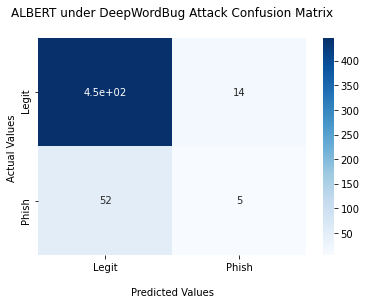

In [9]:
print(confusion_matrix(y_true, prediction_d + prediction_d_400))
confusion_show(confusion_matrix(y_true, prediction_d + prediction_d_400), 'ALBERT', 'DeepWordBug')

[[443  18]
 [  7  50]]


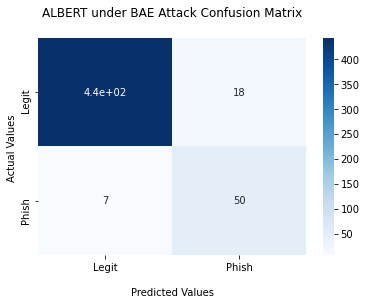

In [11]:
print(confusion_matrix(y_true, prediction_b + prediction_b_400))
confusion_show(confusion_matrix(y_true, prediction_b + prediction_b_400), 'ALBERT', 'BAE')

## ALBERT with augmented data, 1 to 1 ratio

In [18]:
t_aug_failed_examples, t_aug_succeeded_examples, t_aug_attack_examples = parse_text_file('textattack-logs/aug_albert_1_1_textfooler')
p_aug_failed_examples, p_aug_succeeded_examples, p_aug_attack_examples = parse_text_file('textattack-logs/aug_albert_1_1_pwws')
d_aug_failed_examples, d_aug_succeeded_examples, d_aug_attack_examples = parse_text_file('textattack-logs/aug_albert_1_1_deepwordbug')
b_aug_failed_examples, b_aug_succeeded_examples, b_aug_attackexamples = parse_text_file('textattack-logs/bae_aug_albert')

t_aug_400_failed_examples, t_aug_400_succeeded_examples, t_aug_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_aug_albert')
p_aug_400_failed_examples, p_aug_400_succeeded_examples, p_aug_400_attack_examples = parse_text_file('textattack-logs/400_pwws_aug_albert')
d_aug_400_failed_examples, d_aug_400_succeeded_examples, d_aug_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_aug_albert')

t_aug_s_result = clean_up_list(t_aug_succeeded_examples)
p_aug_s_result = clean_up_list(p_aug_succeeded_examples)
d_aug_s_result = clean_up_list(d_aug_succeeded_examples)
b_aug_s_result = clean_up_list(b_aug_succeeded_examples)

t_aug_s_400_result = clean_up_list(t_400_succeeded_examples)
p_aug_s_400_result = clean_up_list(p_400_succeeded_examples)
d_aug_s_400_result = clean_up_list(d_400_succeeded_examples)


In [19]:
prediction_t_aug = extract_label(t_aug_s_result,df_test.iloc[:100])
prediction_p_aug = extract_label(p_aug_s_result,df_test.iloc[:100])
prediction_d_aug = extract_label(d_aug_s_result,df_test.iloc[:100])
prediction_b_aug = extract_label(b_aug_s_result,df_test)

prediction_t_400_aug = extract_label(t_aug_s_400_result,df_test.iloc[100:])
prediction_p_400_aug = extract_label(p_aug_s_400_result,df_test.iloc[100:])
prediction_d_400_aug = extract_label(d_aug_s_400_result,df_test.iloc[100:])


In [20]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_aug + prediction_t_400_aug)
print(confusion_matrix(y_true, prediction_t_aug + prediction_t_400_aug))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_aug + prediction_p_400_aug)
print(confusion_matrix(y_true, prediction_p_aug + prediction_p_400_aug))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_aug + prediction_d_400_aug)
print(confusion_matrix(y_true, prediction_d + prediction_d_400))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_aug)
print(confusion_matrix(y_true, prediction_b_aug))

***********
Textfooler
***********
Accuracy 0.7393822393822393
F1 Score: 0.0689655172413793
Precision: 0.056818181818181816
Recall Score: 0.08771929824561403
MCC:  -0.07693559947818486
[[378  83]
 [ 52   5]]
***********
PWWS
***********
Accuracy 0.8552123552123552
F1 Score: 0.13793103448275862
Precision: 0.2
Recall Score: 0.10526315789473684
MCC:  0.0712768900815337
[[437  24]
 [ 51   6]]
***********
DeepWordBug
***********
Accuracy 0.8648648648648649
F1 Score: 0.14634146341463414
Precision: 0.24
Recall Score: 0.10526315789473684
MCC:  0.09351962602718147
[[447  14]
 [ 52   5]]
***********
BAE
***********
Accuracy 0.8918918918918919
F1 Score: 0.6455696202531646
Precision: 0.504950495049505
Recall Score: 0.8947368421052632
MCC:  0.6210616786253471
[[411  50]
 [  6  51]]


## ALBERT with augmented data, 1 to 2 ratio

In [22]:
t_aug_2_failed_examples, t_aug_2_succeeded_examples, t_aug_2_attack_examples = parse_text_file('textattack-logs/aug_albert_1_2_textfooler')
p_aug_2_failed_examples, p_aug_2_succeeded_examples, p_aug_2_attack_examples = parse_text_file('textattack-logs/aug_albert_1_2_pwws')
d_aug_2_failed_examples, d_aug_2_succeeded_examples, d_aug_2_attack_examples = parse_text_file('textattack-logs/aug_albert_1_2_deepwordbug')
b_aug_2_failed_examples, b_aug_2_succeeded_examples, b_aug_2_attackexamples = parse_text_file('textattack-logs/bae_aug_albert_1_2')

t_aug_2_400_failed_examples, t_aug_2_400_succeeded_examples, t_aug_400_2_attack_examples = parse_text_file('textattack-logs/400_textfooler_aug_albert_1_2')
p_aug_2_400_failed_examples, p_aug_2_400_succeeded_examples, p_aug_400_2_attack_examples = parse_text_file('textattack-logs/400_pwws_aug_albert_1_2')
d_aug_2_400_failed_examples, d_aug_2_400_succeeded_examples, d_aug_400_2_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_aug_albert_1_2')

t_aug_2_s_result = clean_up_list(t_aug_2_succeeded_examples)
p_aug_2_s_result = clean_up_list(p_aug_2_succeeded_examples)
d_aug_2_s_result = clean_up_list(d_aug_2_succeeded_examples)
b_aug_2_s_result = clean_up_list(b_aug_2_succeeded_examples)


t_aug_2_s_400_result = clean_up_list(t_aug_2_400_succeeded_examples)
p_aug_2_s_400_result = clean_up_list(p_aug_2_400_succeeded_examples)
d_aug_2_s_400_result = clean_up_list(d_aug_2_400_succeeded_examples)



In [23]:
prediction_t_aug_2 = extract_label(t_aug_2_s_result,df_test.iloc[:100])
prediction_p_aug_2 = extract_label(p_aug_2_s_result,df_test.iloc[:100])
prediction_d_aug_2 = extract_label(d_aug_2_s_result,df_test.iloc[:100])
prediction_b_aug_2 = extract_label(b_aug_2_s_result,df_test)

prediction_t_400_aug_2 = extract_label(t_aug_2_s_400_result,df_test.iloc[100:])
prediction_p_400_aug_2 = extract_label(p_aug_2_s_400_result,df_test.iloc[100:])
prediction_d_400_aug_2 = extract_label(d_aug_2_s_400_result,df_test.iloc[100:])

In [24]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_aug_2 + prediction_t_400_aug_2)
print(confusion_matrix(y_true, prediction_t_aug_2 + prediction_t_400_aug_2))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_aug_2 + prediction_p_400_aug_2)
print(confusion_matrix(y_true, prediction_p_aug_2 + prediction_p_400_aug_2))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_aug_2 + prediction_d_400_aug_2)
print(confusion_matrix(y_true, prediction_d_aug_2 + prediction_d_400_aug_2))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_aug_2)
print(confusion_matrix(y_true, prediction_b_aug_2))

***********
Textfooler
***********
Accuracy 0.8378378378378378
F1 Score: 0.08695652173913045
Precision: 0.11428571428571428
Recall Score: 0.07017543859649122
MCC:  0.0036533833660666835
[[430  31]
 [ 53   4]]
***********
PWWS
***********
Accuracy 0.8783783783783784
F1 Score: 0.136986301369863
Precision: 0.3125
Recall Score: 0.08771929824561403
MCC:  0.11550272117348775
[[450  11]
 [ 52   5]]
***********
DeepWordBug
***********
Accuracy 0.8783783783783784
F1 Score: 0.11267605633802817
Precision: 0.2857142857142857
Recall Score: 0.07017543859649122
MCC:  0.09356259343862178
[[451  10]
 [ 53   4]]
***********
BAE
***********
Accuracy 0.9459459459459459
F1 Score: 0.7846153846153846
Precision: 0.6986301369863014
Recall Score: 0.8947368421052632
MCC:  0.7617935648910689
[[439  22]
 [  6  51]]


## ALBERT with augmented data, 1 to 4 ratio

In [29]:

t_aug_4_failed_examples, t_aug_4_succeeded_examples, t_aug_4_attack_examples = parse_text_file('textattack-logs/aug_albert_1_4_textfooler')
p_aug_4_failed_examples, p_aug_4_succeeded_examples, p_aug_4_attack_examples = parse_text_file('textattack-logs/aug_albert_1_4_pwws')
d_aug_4_failed_examples, d_aug_4_succeeded_examples, d_aug_4_attack_examples = parse_text_file('textattack-logs/aug_albert_1_4_deepwordbug')
b_aug_4_failed_examples, b_aug_4_succeeded_examples, b_aug_4_attackexamples = parse_text_file('textattack-logs/bae_aug_albert_1_4')


t_aug_4_400_failed_examples, t_aug_4_400_succeeded_examples, t_aug_400_4_attack_examples = parse_text_file('textattack-logs/400_textfooler_aug_albert_1_4')
p_aug_4_400_failed_examples, p_aug_4_400_succeeded_examples, p_aug_400_4_attack_examples = parse_text_file('textattack-logs/400_pwws_aug_albert_1_4')
d_aug_4_400_failed_examples, d_aug_4_400_succeeded_examples, d_aug_400_4_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_aug_albert_1_4')

t_aug_4_s_result = clean_up_list(t_aug_4_succeeded_examples)
p_aug_4_s_result = clean_up_list(p_aug_4_succeeded_examples)
d_aug_4_s_result = clean_up_list(d_aug_4_succeeded_examples)
b_aug_4_s_result = clean_up_list(b_aug_4_succeeded_examples)


t_aug_4_s_400_result = clean_up_list(t_aug_4_400_succeeded_examples)
p_aug_4_s_400_result = clean_up_list(p_aug_4_400_succeeded_examples)
d_aug_4_s_400_result = clean_up_list(d_aug_4_400_succeeded_examples)


In [30]:
prediction_t_aug_4 = extract_label(t_aug_4_s_result,df_test.iloc[:100])
prediction_p_aug_4 = extract_label(p_aug_4_s_result,df_test.iloc[:100])
prediction_d_aug_4 = extract_label(d_aug_4_s_result,df_test.iloc[:100])
prediction_b_aug_4 = extract_label(b_aug_4_s_result,df_test)

prediction_t_400_aug_4 = extract_label(t_aug_4_s_400_result,df_test.iloc[100:])
prediction_p_400_aug_4 = extract_label(p_aug_4_s_400_result,df_test.iloc[100:])
prediction_d_400_aug_4 = extract_label(d_aug_4_s_400_result,df_test.iloc[100:])

In [31]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_aug_4 + prediction_t_400_aug_4)
print(confusion_matrix(y_true, prediction_t_aug_4 + prediction_t_400_aug_4))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_aug_4 + prediction_p_400_aug_4)
print(confusion_matrix(y_true, prediction_p_aug_4 + prediction_p_400_aug_4))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_aug_4 + prediction_d_400_aug_4)
print(confusion_matrix(y_true, prediction_d_aug_4 + prediction_d_400_aug_4))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_aug_4)
print(confusion_matrix(y_true, prediction_b_aug_4))

***********
Textfooler
***********
Accuracy 0.6833976833976834
F1 Score: 0.11827956989247312
Precision: 0.08527131782945736
Recall Score: 0.19298245614035087
MCC:  -0.04557644551712784
[[343 118]
 [ 46  11]]
***********
PWWS
***********
Accuracy 0.8378378378378378
F1 Score: 0.25
Precision: 0.2545454545454545
Recall Score: 0.24561403508771928
MCC:  0.15915531123430407
[[420  41]
 [ 43  14]]
***********
DeepWordBug
***********
Accuracy 0.805019305019305
F1 Score: 0.20472440944881892
Precision: 0.18571428571428572
Recall Score: 0.22807017543859648
MCC:  0.09558905969578116
[[404  57]
 [ 44  13]]
***********
BAE
***********
Accuracy 0.9285714285714286
F1 Score: 0.7412587412587412
Precision: 0.6162790697674418
Recall Score: 0.9298245614035088
MCC:  0.7217820432129437
[[428  33]
 [  4  53]]


## ALBERT with adversarial data

In [38]:
t_adv_failed_examples, t_adv_succeeded_examples, t_adv_attack_examples = parse_text_file('textattack-logs/albert_adv_textfooler')
p_adv_failed_examples, p_adv_succeeded_examples, p_adv_attack_examples = parse_text_file('textattack-logs/albert_adv_pwws')
d_adv_failed_examples, d_adv_succeeded_examples, d_adv_attack_examples = parse_text_file('textattack-logs/albert_adv_deepwordbug')
b_adv_failed_examples, b_adv_succeeded_examples, b_adv_attack_examples = parse_text_file('textattack-logs/bae_albert_adv')


t_adv_400_failed_examples, t_adv_400_succeeded_examples, t_adv_400_attack_examples = parse_text_file('textattack-logs/400_albert_adv_textfooler')
p_adv_400_failed_examples, p_adv_400_succeeded_examples, p_adv_400_attack_examples = parse_text_file('textattack-logs/400_pwws_albert_adv')
d_adv_400_failed_examples, d_adv_400_succeeded_examples, d_adv_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_albert_adv')

#del t_adv_400_succeeded_examples[21]
#del p_adv_400_succeeded_examples[20]
#del d_adv_400_succeeded_examples[20]

t_adv_s_result = clean_up_list(t_adv_succeeded_examples)
p_adv_s_result = clean_up_list(p_adv_succeeded_examples)
d_adv_s_result = clean_up_list(d_adv_succeeded_examples)
b_adv_s_result = clean_up_list(b_adv_succeeded_examples)
                               
t_adv_s_400_result = clean_up_list(t_adv_400_succeeded_examples)
p_adv_s_400_result = clean_up_list(p_adv_400_succeeded_examples)
d_adv_s_400_result = clean_up_list(d_adv_400_succeeded_examples)

In [39]:
prediction_t_adv = extract_label(t_adv_s_result,df_test.iloc[:100])
prediction_p_adv = extract_label(p_adv_s_result,df_test.iloc[:100])
prediction_d_adv = extract_label(d_adv_s_result,df_test.iloc[:100])
prediction_b_adv = extract_label(b_adv_s_result,df_test)

prediction_t_400_adv = extract_label(t_adv_s_400_result,df_test.iloc[100:])
prediction_p_400_adv = extract_label(p_adv_s_400_result,df_test.iloc[100:])
prediction_d_400_adv = extract_label(d_adv_s_400_result,df_test.iloc[100:])

In [40]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_adv + prediction_t_400_adv)
print(confusion_matrix(y_true, prediction_t_adv + prediction_t_400_adv))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_adv + prediction_p_400_adv)
print(confusion_matrix(y_true, prediction_p_adv + prediction_p_400_adv))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_adv + prediction_d_400_adv)
print(confusion_matrix(y_true, prediction_d_adv + prediction_d_400_adv))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_adv)
print(confusion_matrix(y_true, prediction_b_adv))

***********
Textfooler
***********
Accuracy 0.8841698841698842
F1 Score: 0.14285714285714285
Precision: 0.38461538461538464
Recall Score: 0.08771929824561403
MCC:  0.14077698359630386
[[453   8]
 [ 52   5]]
***********
PWWS
***********
Accuracy 0.8938223938223938
F1 Score: 0.22535211267605634
Precision: 0.5714285714285714
Recall Score: 0.14035087719298245
MCC:  0.24573032782231433
[[455   6]
 [ 49   8]]
***********
DeepWordBug
***********
Accuracy 0.8861003861003861
F1 Score: 0.16901408450704228
Precision: 0.42857142857142855
Recall Score: 0.10526315789473684
MCC:  0.16964646063046807
[[453   8]
 [ 51   6]]
***********
BAE
***********
Accuracy 0.9691119691119691
F1 Score: 0.8688524590163934
Precision: 0.8153846153846154
Recall Score: 0.9298245614035088
MCC:  0.8537911673707208
[[449  12]
 [  4  53]]


## ALBERT with half of adversarial data

In [44]:
t_adv_half_failed_examples, t_adv_half_succeeded_examples, t_adv_half_attack_examples = parse_text_file('textattack-logs/albert_adv_half_textfooler')
p_adv_half_failed_examples, p_adv_half_succeeded_examples, p_adv_half_attack_examples = parse_text_file('textattack-logs/albert_adv_half_pwws')
d_adv_half_failed_examples, d_adv_half_succeeded_examples, d_adv_half_attack_examples = parse_text_file('textattack-logs/albert_adv_half_deepwordbug')
b_adv_half_failed_examples, b_adv_half_succeeded_examples, b_adv_half_attack_examples = parse_text_file('textattack-logs/bae_albert_adv_half')


t_adv_half_400_failed_examples, t_adv_half_400_succeeded_examples, t_adv_half_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_albert_adv_half')
p_adv_half_400_failed_examples, p_adv_half_400_succeeded_examples, p_adv_half_400_attack_examples = parse_text_file('textattack-logs/400_pwws_albert_adv_half')
d_adv_half_400_failed_examples, d_adv_half_400_succeeded_examples, d_adv_half_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_albert_adv_half')


t_adv_half_s_result = clean_up_list(t_adv_half_succeeded_examples)
p_adv_half_s_result = clean_up_list(p_adv_half_succeeded_examples)
d_adv_half_s_result = clean_up_list(d_adv_half_succeeded_examples)
b_adv_half_s_result = clean_up_list(b_adv_succeeded_examples)
                               
t_adv_half_s_400_result = clean_up_list(t_adv_half_400_succeeded_examples)
p_adv_half_s_400_result = clean_up_list(p_adv_half_400_succeeded_examples)
d_adv_half_s_400_result = clean_up_list(d_adv_half_400_succeeded_examples)


prediction_t_adv_half = extract_label(t_adv_half_s_result,df_test.iloc[:100])
prediction_p_adv_half = extract_label(p_adv_half_s_result,df_test.iloc[:100])
prediction_d_adv_half = extract_label(d_adv_half_s_result,df_test.iloc[:100])
prediction_b_adv_half = extract_label(b_adv_half_s_result,df_test)

prediction_t_400_adv_half = extract_label(t_adv_half_s_400_result,df_test.iloc[100:])
prediction_p_400_adv_half = extract_label(p_adv_half_s_400_result,df_test.iloc[100:])
prediction_d_400_adv_half = extract_label(d_adv_half_s_400_result,df_test.iloc[100:])

In [42]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_adv_half + prediction_t_400_adv_half)
print(confusion_matrix(y_true, prediction_t_adv_half + prediction_t_400_adv_half))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_adv_half + prediction_p_400_adv_half)
print(confusion_matrix(y_true, prediction_p_adv_half + prediction_p_400_adv_half))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_adv_half + prediction_d_400_adv_half)
print(confusion_matrix(y_true, prediction_d_adv_half + prediction_d_400_adv_half))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_adv_half)
print(confusion_matrix(y_true, prediction_b_adv_half))

***********
Textfooler
***********
Accuracy 0.8571428571428571
F1 Score: 0.28846153846153844
Precision: 0.3191489361702128
Recall Score: 0.2631578947368421
MCC:  0.21108424719779792
[[429  32]
 [ 42  15]]
***********
PWWS
***********
Accuracy 0.8957528957528957
F1 Score: 0.39999999999999997
Precision: 0.5454545454545454
Recall Score: 0.3157894736842105
MCC:  0.3629378725889971
[[446  15]
 [ 39  18]]
***********
DeepWordBug
***********
Accuracy 0.9111969111969112
F1 Score: 0.4888888888888889
Precision: 0.6666666666666666
Recall Score: 0.38596491228070173
MCC:  0.463973378702715
[[450  11]
 [ 35  22]]
***********
BAE
***********
Accuracy 0.9691119691119691
F1 Score: 0.8688524590163934
Precision: 0.8153846153846154
Recall Score: 0.9298245614035088
MCC:  0.8537911673707208
[[449  12]
 [  4  53]]


In [45]:
t_r_failed_examples, t_r_succeeded_examples, t_r_attack_examples = parse_text_file('textattack-logs/roberta_textfooler')
p_r_failed_examples, p_r_succeeded_examples, p_r_attack_examples = parse_text_file('textattack-logs/roberta_pwws')
d_r_failed_examples, d_r_succeeded_examples, d_r_attack_examples = parse_text_file('textattack-logs/roberta_deepwordbug')

t_r_adv_half_failed_examples, t_r_adv_half_succeeded_examples, t_r_adv_half_attack_examples = parse_text_file('textattack-logs/roberta_adv_half_textfooler')
p_r_adv_half_failed_examples, p_r_adv_half_succeeded_examples, p_r_adv_half_attack_examples = parse_text_file('textattack-logs/roberta_adv_half_pwws')
d_r_adv_half_failed_examples, d_r_adv_half_succeeded_examples, d_r_adv_half_attack_examples = parse_text_file('textattack-logs/roberta_adv_half_deepwordbug')


t_r_adv_failed_examples, t_r_adv_succeeded_examples, t_r_adv_attack_examples = parse_text_file('textattack-logs/roberta_adv_textfooler')
p_r_adv_failed_examples, p_r_adv_succeeded_examples, p_r_adv_attack_examples = parse_text_file('textattack-logs/roberta_adv_pwws')
d_r_adv_failed_examples, d_r_adv_succeeded_examples, d_r_adv_attack_examples = parse_text_file('textattack-logs/roberta_adv_deepwordbug')

t_r_s_result = clean_up_list(t_r_succeeded_examples)
p_r_s_result = clean_up_list(p_r_succeeded_examples)
d_r_s_result = clean_up_list(d_r_succeeded_examples)

t_r_adv_half_s_result = clean_up_list(t_r_adv_half_succeeded_examples)
p_r_adv_half_s_result = clean_up_list(p_r_adv_half_succeeded_examples)
d_r_adv_half_s_result = clean_up_list(d_r_adv_half_succeeded_examples)
#b_adv_half_s_result = clean_up_list(b_adv_half_succeeded_examples)

t_r_adv_s_result = clean_up_list(t_r_adv_succeeded_examples)
p_r_adv_s_result = clean_up_list(p_r_adv_succeeded_examples)
d_r_adv_s_result = clean_up_list(d_r_adv_succeeded_examples)


## Deberta

In [47]:
t_d_failed_examples, t_d_succeeded_examples, t_d_attack_examples = parse_text_file('textattack-logs/deberta_textfooler')
p_d_failed_examples, p_d_succeeded_examples, p_d_attack_examples = parse_text_file('textattack-logs/deberta_pwws')
d_d_failed_examples, d_d_succeeded_examples, d_d_attack_examples = parse_text_file('textattack-logs/deberta_deepwordbug')
b_d_failed_examples, b_d_succeeded_examples, b_d_attack_examples = parse_text_file('textattack-logs/deberta_bae')

t_d_400_failed_examples, t_d_400_succeeded_examples, t_d_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_deberta')
p_d_400_failed_examples, p_d_400_succeeded_examples, p_d_400_attack_examples = parse_text_file('textattack-logs/400_pwws_deberta')
d_d_400_failed_examples, d_d_400_succeeded_examples, d_d_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_deberta')
b_d_400_failed_examples, b_d_400_succeeded_examples, b_d_400_attack_examples = parse_text_file('textattack-logs/400_bae_deberta')

t_d_s_result = clean_up_list(t_d_succeeded_examples)
p_d_s_result = clean_up_list(p_d_succeeded_examples)
d_d_s_result = clean_up_list(d_d_succeeded_examples)
b_d_s_result = clean_up_list(b_d_succeeded_examples)


t_d_s_400_result = clean_up_list(t_d_400_succeeded_examples)
p_d_s_400_result = clean_up_list(p_d_400_succeeded_examples)
d_d_s_400_result = clean_up_list(d_d_400_succeeded_examples)
b_d_s_400_result = clean_up_list(b_d_400_succeeded_examples)


prediction_t_d = extract_label(t_d_s_result,df_test.iloc[:100])
prediction_p_d = extract_label(p_d_s_result,df_test.iloc[:100])
prediction_d_d = extract_label(d_d_s_result,df_test.iloc[:100])
prediction_b_d = extract_label(b_d_s_result,df_test.iloc[:100])

prediction_t_400_d = extract_label(t_d_s_400_result,df_test.iloc[100:])
prediction_p_400_d = extract_label(p_d_s_400_result,df_test.iloc[100:])
prediction_d_400_d = extract_label(d_d_s_400_result,df_test.iloc[100:])
prediction_b_400_d = extract_label(b_d_s_400_result,df_test.iloc[100:])


y_true = df_test['label'].tolist()


print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_d + prediction_t_400_d)
print(confusion_matrix(y_true, prediction_t_d + prediction_t_400_d))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_d + prediction_p_400_d)
print(confusion_matrix(y_true, prediction_p_d + prediction_p_400_d))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_d + prediction_d_400_d)
print(confusion_matrix(y_true, prediction_d_d + prediction_d_400_d))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_d + prediction_b_400_d)
print(confusion_matrix(y_true, prediction_b_d + prediction_b_400_d))



***********
Textfooler
***********
Accuracy 0.6447876447876448
F1 Score: 0.0707070707070707
Precision: 0.04964539007092199
Recall Score: 0.12280701754385964
MCC:  -0.11802362127848348
[[327 134]
 [ 50   7]]
***********
PWWS
***********
Accuracy 0.8088803088803089
F1 Score: 0.12389380530973451
Precision: 0.125
Recall Score: 0.12280701754385964
MCC:  0.016645116444358295
[[412  49]
 [ 50   7]]
***********
DeepWordBug
***********
Accuracy 0.8667953667953668
F1 Score: 0.14814814814814814
Precision: 0.25
Recall Score: 0.10526315789473684
MCC:  0.09858078280026614
[[443  18]
 [ 51   6]]
***********
BAE
***********
Accuracy 0.9401544401544402
F1 Score: 0.776978417266187
Precision: 0.6585365853658537
Recall Score: 0.9473684210526315
MCC:  0.7601172344349402
[[433  28]
 [  3  54]]


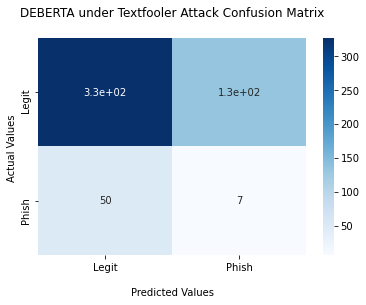

In [134]:
confusion_show(confusion_matrix(y_true, prediction_t_d + prediction_t_400_d), 'DEBERTA', 'Textfooler')

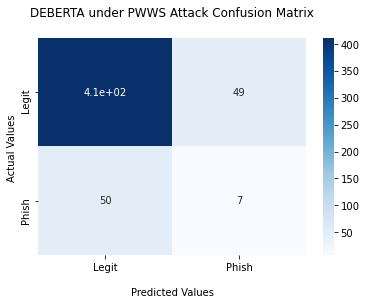

In [135]:
confusion_show(confusion_matrix(y_true, prediction_p_d + prediction_p_400_d), 'DEBERTA', 'PWWS')

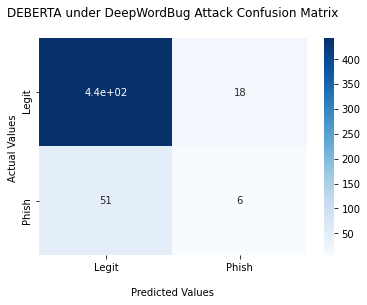

In [136]:
confusion_show(confusion_matrix(y_true, prediction_d_d + prediction_d_400_d), 'DEBERTA', 'DeepWordBug')

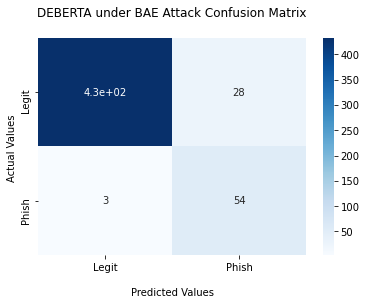

In [138]:
confusion_show(confusion_matrix(y_true, prediction_b_d + prediction_b_400_d), 'DEBERTA', 'BAE')

## Roberta

In [49]:
t_r_failed_examples, t_r_succeeded_examples, t_r_attack_examples = parse_text_file('textattack-logs/roberta_textfooler')
p_r_failed_examples, p_r_succeeded_examples, p_r_attack_examples = parse_text_file('textattack-logs/roberta_pwws')
d_r_failed_examples, d_r_succeeded_examples, d_r_attack_examples = parse_text_file('textattack-logs/roberta_deepwordbug')
b_r_failed_examples, b_r_succeeded_examples, b_r_attack_examples = parse_text_file('textattack-logs/bae_roberta')

t_r_400_failed_examples, t_r_400_succeeded_examples, t_r_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_roberta')
p_r_400_failed_examples, p_r_400_succeeded_examples, p_r_400_attack_examples = parse_text_file('textattack-logs/400_pwws_roberta')
d_r_400_failed_examples, d_r_400_succeeded_examples, d_r_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_roberta')
#b_r_400_failed_examples, b_r_400_succeeded_examples, b_r_400_attack_examples = parse_text_file('400_bae_roberta')
#del b_r_succeeded_examples[8]
t_r_s_result = clean_up_list(t_r_succeeded_examples)
p_r_s_result = clean_up_list(p_r_succeeded_examples)
d_r_s_result = clean_up_list(d_r_succeeded_examples)
b_r_s_result = clean_up_list(b_r_succeeded_examples)



t_r_s_400_result = clean_up_list(t_r_400_succeeded_examples)
p_r_s_400_result = clean_up_list(p_r_400_succeeded_examples)
d_r_s_400_result = clean_up_list(d_r_400_succeeded_examples)
#b_r_s_400_result = clean_up_list(b_r_400_succeeded_examples)


prediction_t_r = extract_label(t_r_s_result,df_test.iloc[:100])
prediction_p_r = extract_label(p_r_s_result,df_test.iloc[:100])
prediction_d_r = extract_label(d_r_s_result,df_test.iloc[:100])
prediction_b_r = extract_label(b_r_s_result,df_test)

prediction_t_400_r = extract_label(t_r_s_400_result,df_test.iloc[100:])
prediction_p_400_r = extract_label(p_r_s_400_result,df_test.iloc[100:])
prediction_d_400_r = extract_label(d_r_s_400_result,df_test.iloc[100:])
#prediction_b_400_r = extract_label(b_r_s_400_result,df_test.iloc[100:])


y_true = df_test['label'].tolist()


print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_r + prediction_t_400_r)
print(confusion_matrix(y_true, prediction_t_r + prediction_t_400_r))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_r + prediction_p_400_r)
print(confusion_matrix(y_true, prediction_p_r + prediction_p_400_r))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_r + prediction_d_400_r)
print(confusion_matrix(y_true, prediction_d_r + prediction_d_400_r))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_r)
print(confusion_matrix(y_true, prediction_b_r))


***********
Textfooler
***********
Accuracy 0.7142857142857143
F1 Score: 0.1395348837209302
Precision: 0.10434782608695652
Recall Score: 0.21052631578947367
MCC:  -0.009714274345384296
[[358 103]
 [ 45  12]]
***********
PWWS
***********
Accuracy 0.8416988416988417
F1 Score: 0.31666666666666665
Precision: 0.30158730158730157
Recall Score: 0.3333333333333333
MCC:  0.22776429055079692
[[417  44]
 [ 38  19]]
***********
DeepWordBug
***********
Accuracy 0.8918918918918919
F1 Score: 0.3333333333333333
Precision: 0.5185185185185185
Recall Score: 0.24561403508771928
MCC:  0.30609321672780865
[[448  13]
 [ 43  14]]
***********
BAE
***********
Accuracy 0.916988416988417
F1 Score: 0.703448275862069
Precision: 0.5795454545454546
Recall Score: 0.8947368421052632
MCC:  0.6787204039703679
[[424  37]
 [  6  51]]


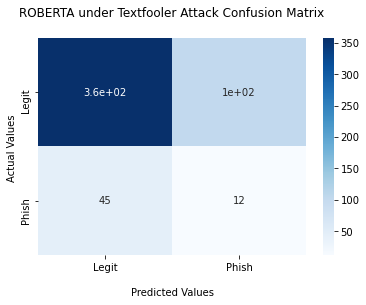

In [151]:
confusion_show(confusion_matrix(y_true, prediction_t_r + prediction_t_400_r), 'ROBERTA', 'Textfooler')

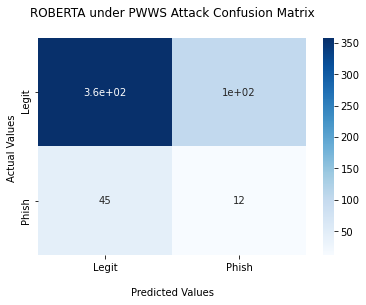

In [152]:
confusion_show(confusion_matrix(y_true, prediction_t_r + prediction_t_400_r), 'ROBERTA', 'PWWS')

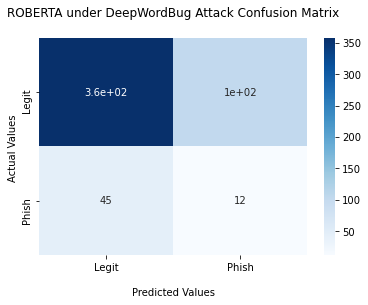

In [153]:
confusion_show(confusion_matrix(y_true, prediction_t_r + prediction_t_400_r), 'ROBERTA', 'DeepWordBug')

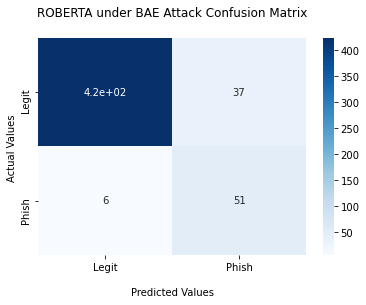

In [159]:
confusion_show(confusion_matrix(y_true, prediction_b_r),'ROBERTA','BAE')

## Yoso

In [51]:
t_y_failed_examples, t_y_succeeded_examples, t_y_attack_examples = parse_text_file('textattack-logs/yoso_textfooler')
p_y_failed_examples, p_y_succeeded_examples, p_y_attack_examples = parse_text_file('textattack-logs/yoso_pwws')
d_y_failed_examples, d_y_succeeded_examples, d_y_attack_examples = parse_text_file('textattack-logs/yoso_deepwordbug')
b_y_failed_examples, b_y_succeeded_examples, b_y_attack_examples = parse_text_file('textattack-logs/yoso_bae')

t_y_400_failed_examples, t_y_400_succeeded_examples, t_y_400_attack_examples = parse_text_file('textattack-logs/400_textfooler_yoso')
p_y_400_failed_examples, p_y_400_succeeded_examples, p_y_400_attack_examples = parse_text_file('textattack-logs/400_pwws_yoso')
d_y_400_failed_examples, d_y_400_succeeded_examples, d_y_400_attack_examples = parse_text_file('textattack-logs/400_deepwordbug_yoso')
b_y_400_failed_examples, b_y_400_succeeded_examples, b_y_400_attack_examples = parse_text_file('textattack-logs/400_bae_yoso')


t_y_s_result = clean_up_list(t_y_succeeded_examples)
p_y_s_result = clean_up_list(p_y_succeeded_examples)
d_y_s_result = clean_up_list(d_y_succeeded_examples)
b_y_s_result = clean_up_list(b_y_succeeded_examples)


t_y_s_400_result = clean_up_list(t_y_400_succeeded_examples)
p_y_s_400_result = clean_up_list(p_y_400_succeeded_examples)
d_y_s_400_result = clean_up_list(d_y_400_succeeded_examples)
b_y_s_400_result = clean_up_list(b_y_400_succeeded_examples)


prediction_t_y = extract_label(t_y_s_result,df_test.iloc[:100])
prediction_p_y = extract_label(p_y_s_result,df_test.iloc[:100])
prediction_d_y = extract_label(d_y_s_result,df_test.iloc[:100])
prediction_b_y = extract_label(b_y_s_result,df_test.iloc[:100])


prediction_t_400_y = extract_label(t_y_s_400_result,df_test.iloc[100:])
prediction_p_400_y = extract_label(p_y_s_400_result,df_test.iloc[100:])
prediction_d_400_y = extract_label(d_y_s_400_result,df_test.iloc[100:])
prediction_b_400_y = extract_label(b_y_s_400_result,df_test.iloc[100:])




print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_y + prediction_t_400_y)
print(confusion_matrix(y_true, prediction_t_y + prediction_t_400_y))
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_y + prediction_p_400_y)
print(confusion_matrix(y_true, prediction_p_y + prediction_p_400_y))
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_y + prediction_d_400_y)
print(confusion_matrix(y_true, prediction_d_y + prediction_d_400_y))
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_y + prediction_b_400_y)
print(confusion_matrix(y_true, prediction_b_y + prediction_b_400_y))


***********
Textfooler
***********
Accuracy 0.3687258687258687
F1 Score: 0.012084592145015106
Precision: 0.0072992700729927005
Recall Score: 0.03508771929824561
MCC:  -0.3479036689499173
[[189 272]
 [ 55   2]]
***********
PWWS
***********
Accuracy 0.7393822393822393
F1 Score: 0.10596026490066224
Precision: 0.0851063829787234
Recall Score: 0.14035087719298245
MCC:  -0.03751318519714794
[[375  86]
 [ 49   8]]
***********
DeepWordBug
***********
Accuracy 0.862934362934363
F1 Score: 0.10126582278481013
Precision: 0.18181818181818182
Recall Score: 0.07017543859649122
MCC:  0.04830735227688816
[[443  18]
 [ 53   4]]
***********
BAE
***********
Accuracy 0.8938223938223938
F1 Score: 0.6583850931677018
Precision: 0.5096153846153846
Recall Score: 0.9298245614035088
MCC:  0.6399685105690816
[[410  51]
 [  4  53]]


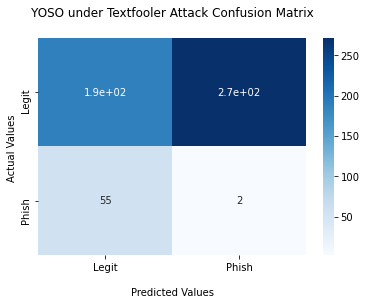

In [139]:
confusion_show(confusion_matrix(y_true, prediction_t_y + prediction_t_400_y), 'YOSO', 'Textfooler')

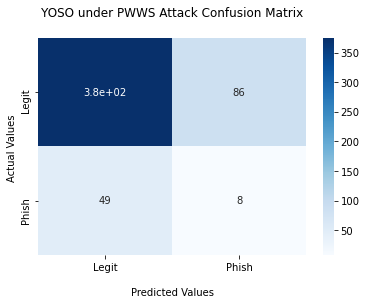

In [140]:
confusion_show(confusion_matrix(y_true, prediction_p_y + prediction_p_400_y), 'YOSO', 'PWWS')

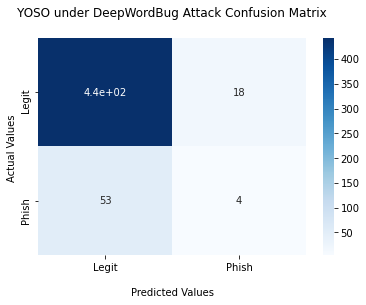

In [141]:
confusion_show(confusion_matrix(y_true, prediction_d_y + prediction_d_400_y), 'YOSO', 'DeepWordBug')

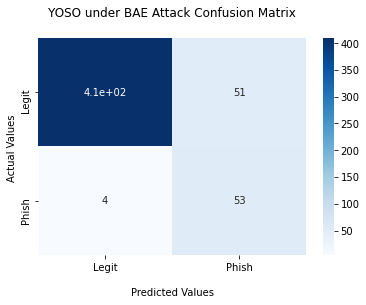

In [165]:
confusion_show(confusion_matrix(y_true, prediction_b_y + prediction_b_400_y),'YOSO','BAE')

In [175]:
confusion_matrix(y_true, prediction_b_y + prediction_b_400_y)

array([[410,  51],
       [  4,  53]])

## Bert

In [52]:
t_b_failed_examples, t_b_succeeded_examples, t_b_attack_examples = parse_text_file('textattack-logs/bert_textfooler')
p_b_failed_examples, p_b_succeeded_examples, p_b_attack_examples = parse_text_file('textattack-logs/bert_pwws')
d_b_failed_examples, d_b_succeeded_examples, d_b_attack_examples = parse_text_file('textattack-logs/bert_deepwordbug')
b_b_failed_examples, b_b_succeeded_examples, b_b_attack_examples = parse_text_file('textattack-logs/bert_bae')


t_b_s_result = clean_up_list(t_b_succeeded_examples)
p_b_s_result = clean_up_list(p_b_succeeded_examples)
d_b_s_result = clean_up_list(d_b_succeeded_examples)
b_b_s_result = clean_up_list(b_b_succeeded_examples)

## Distilbert

In [53]:
t_di_failed_examples, t_di_succeeded_examples, t_di_attack_examples = parse_text_file('textattack-logs/distilbert_textfooler')
p_di_failed_examples, p_di_succeeded_examples, p_di_attack_examples = parse_text_file('textattack-logs/distilbert_pwws')
d_di_failed_examples, d_di_succeeded_examples, d_di_attack_examples = parse_text_file('textattack-logs/distilbert_deepwordbug')



t_di_s_result = clean_up_list(t_di_succeeded_examples)
p_di_s_result = clean_up_list(p_di_succeeded_examples)
d_di_s_result = clean_up_list(d_di_succeeded_examples)



## Squeezbert

In [54]:
t_sq_failed_examples, t_sq_succeeded_examples, t_sq_attack_examples = parse_text_file('textattack-logs/squeezbert_textfooler')
p_sq_failed_examples, p_sq_succeeded_examples, p_sq_attack_examples = parse_text_file('textattack-logs/squeezbert_pwws')
d_sq_failed_examples, d_sq_succeeded_examples, d_sq_attack_examples = parse_text_file('textattack-logs/squeezbert_deepwordbug')
b_sq_failed_examples, b_sq_succeeded_examples, b_sq_attack_examples = parse_text_file('textattack-logs/squeezebert_bae')



t_sq_s_result = clean_up_list(t_sq_succeeded_examples)
p_sq_s_result = clean_up_list(p_sq_succeeded_examples)
d_sq_s_result = clean_up_list(d_sq_succeeded_examples)
b_sq_s_result = clean_up_list(b_sq_succeeded_examples)

In [36]:
df_test = pd.read_csv('test_emails.csv')

In [43]:
y_true = df_test.iloc[:100]['label'].tolist()

In [39]:
prediction_t_b = extract_label(t_b_s_result,df_test.iloc[:100])
prediction_p_b = extract_label(p_b_s_result,df_test.iloc[:100])
prediction_d_b = extract_label(d_b_s_result,df_test.iloc[:100])

prediction_b_b = extract_label(b_b_s_result,df_test.iloc[:100])

In [40]:
prediction_t_di = extract_label(t_di_s_result,df_test.iloc[:100])
prediction_p_di = extract_label(p_di_s_result,df_test.iloc[:100])
prediction_d_di = extract_label(d_di_s_result,df_test.iloc[:100])

In [41]:
prediction_t_sq = extract_label(t_sq_s_result,df_test.iloc[:100])
prediction_p_sq = extract_label(p_sq_s_result,df_test.iloc[:100])
prediction_d_sq = extract_label(d_sq_s_result,df_test.iloc[:100])

prediction_b_sq = extract_label(b_sq_s_result,df_test.iloc[:100])

In [46]:
prediction_t_d = extract_label(t_d_s_result,df_test.iloc[:100])
prediction_p_d = extract_label(p_d_s_result,df_test.iloc[:100])
prediction_d_d = extract_label(d_d_s_result,df_test.iloc[:100])

prediction_b_d = extract_label(b_d_s_result,df_test.iloc[:100])

prediction_t_d_adv_half = extract_label(t_d_adv_half_s_result,df_test.iloc[:100])
prediction_p_d_adv_half = extract_label(p_d_adv_half_s_result,df_test.iloc[:100])
#prediction_d_d_adv_half = extract_label(d_d_adv_half_s_result,df_test.iloc[:100])

prediction_t_d_adv = extract_label(t_d_adv_s_result,df_test.iloc[:100])
prediction_p_d_adv = extract_label(p_d_adv_s_result,df_test.iloc[:100])
prediction_d_d_adv = extract_label(d_d_adv_s_result,df_test.iloc[:100])

In [48]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_d)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_d)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_d)
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_d)

confusion_matrix(y_true, prediction_b_d)

***********
Textfooler
***********
Accuracy 0.63
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.19611613513818402
***********
PWWS
***********
Accuracy 0.83
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.09273670016027795
***********
DeepWordBug
***********
Accuracy 0.86
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.07214791053658227
***********
BAE
***********
Accuracy 0.96
F1 Score: 0.7999999999999999
Precision: 0.7272727272727273
Recall Score: 0.8888888888888888
MCC:  0.7828611134702519


array([[88,  3],
       [ 1,  8]])

In [44]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_b)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_b)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_b)
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_b)

confusion_matrix(y_true, prediction_t_b)

***********
Textfooler
***********
Accuracy 0.64
F1 Score: 0.09999999999999999
Precision: 0.06451612903225806
Recall Score: 0.2222222222222222
MCC:  -0.05968699962629431
***********
PWWS
***********
Accuracy 0.84
F1 Score: 0.27272727272727276
Precision: 0.23076923076923078
Recall Score: 0.3333333333333333
MCC:  0.19014190310330606
***********
DeepWordBug
***********
Accuracy 0.85
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.07945335801632392
***********
BAE
***********
Accuracy 0.95
F1 Score: 0.761904761904762
Precision: 0.6666666666666666
Recall Score: 0.8888888888888888
MCC:  0.7441015076500341


array([[62, 29],
       [ 7,  2]])

In [45]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_di)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_di)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_di)
print('***********')

***********
Textfooler
***********
Accuracy 0.71
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.15724272550828777
***********
PWWS
***********
Accuracy 0.79
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.11613144917081457
***********
DeepWordBug
***********
Accuracy 0.88
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.05530639088956956
***********


In [46]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_sq)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_sq)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_sq)
print('***********')
print('BAE')
print('***********')
print_metrics(y_true, prediction_b_sq)

confusion_matrix(y_true, prediction_b_sq)

***********
Textfooler
***********
Accuracy 0.55
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.2358640882624316
***********
PWWS
***********
Accuracy 0.76
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.13211031413252308
***********
DeepWordBug
***********
Accuracy 0.88
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.05530639088956956
***********
BAE
***********
Accuracy 0.94
F1 Score: 0.7272727272727274
Precision: 0.6153846153846154
Recall Score: 0.8888888888888888
MCC:  0.7096552995604264


array([[86,  5],
       [ 1,  8]])

In [60]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_r)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_r)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_r)

***********
Textfooler
***********
Accuracy 0.71
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.15724272550828777
***********
PWWS
***********
Accuracy 0.81
F1 Score: 0.09523809523809525
Precision: 0.08333333333333333
Recall Score: 0.1111111111111111
MCC:  -0.008602329568208486
***********
DeepWordBug
***********
Accuracy 0.89
F1 Score: 0.0
Precision: 0.0
Recall Score: 0.0
MCC:  -0.04492649300236792


In [38]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_r_adv_half)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_r_adv_half)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_r_adv_half)

***********
Textfooler
***********
Accuracy 0.92
F1 Score: 0.5
Precision: 0.5714285714285714
Recall Score: 0.4444444444444444
MCC:  0.4615273642357336
***********
PWWS
***********
Accuracy 0.94
F1 Score: 0.6666666666666666
Precision: 0.6666666666666666
Recall Score: 0.6666666666666666
MCC:  0.6336996336996337
***********
DeepWordBug
***********
Accuracy 0.93
F1 Score: 0.5333333333333333
Precision: 0.6666666666666666
Recall Score: 0.4444444444444444
MCC:  0.5090900346971865


In [37]:
print('***********')
print('Textfooler')
print('***********')
print_metrics(y_true, prediction_t_r_adv)
print('***********')
print('PWWS')
print('***********')
print_metrics(y_true, prediction_p_r_adv)
print('***********')
print('DeepWordBug')
print('***********')
print_metrics(y_true, prediction_d_r_adv)

***********
Textfooler
***********
Accuracy 0.86
F1 Score: 0.3
Precision: 0.2727272727272727
Recall Score: 0.3333333333333333
MCC:  0.2244723021505287
***********
PWWS
***********
Accuracy 0.87
F1 Score: 0.3157894736842105
Precision: 0.3
Recall Score: 0.3333333333333333
MCC:  0.24459979523511427
***********
DeepWordBug
***********
Accuracy 0.95
F1 Score: 0.6666666666666667
Precision: 0.8333333333333334
Recall Score: 0.5555555555555556
MCC:  0.6562258828755642
